Работа такого сервиса, как Сбермаркет, в первую очередь завязана на курьера. Когда пользователь делает заказ в продуктовом интернет магазине, то первое, на что он будет обращать внимание - качество доставки и состояние доставленных товаров. Поэтому важной метрикой, за которой необходимо следить каждый день являются численные оценки и отзывы пользователей по доставленным заказам. 

Критично следить за ежедневным количеством оформленных и доставленных заказов. Очевидно, что такие данные могут обладать сезональностью и метрики могут проседать, например, в рабочие будни, но сравнение метрик за периоды времени могжет многое сказать о "здоровье" бизнеса.

Сервису необходимо привлекать новую аудиторию. Следить за такой метрикой можно, например, анализируя использование покупателями особых промокодов. У Сбермаркета есть конкуренты на рынке, поэтому стоит также смотреть и за оттоком постоянных пользователей. Если покупатель совершал покупки в течение года каждые две недели, а потом перестал пользоваться сервисом на три месяца, то, вероятно, он отдал предпочтение другому сервису. Отслеживая данные о таких ситауциях можно делать выводы о причиных оттока.

#**Библиотеки и функции**

In [ ]:
!pip install psycopg2
import psycopg2
import pandas as pd
import numpy as np

def request(sql_req):
    conn = psycopg2.connect(dbname="hr-analytics", user="analytics", password="HRanalytics", host="rc1c-fhrb9f1e0l9g611h.mdb.yandexcloud.net", port="6432")
    cursor = conn.cursor()
    cursor.execute(sql_req)
    records = cursor.fetchall()
    cursor.close()
    conn.close()
    return pd.DataFrame(records)

#**Время доставки**

Посмотрим на распределение времени, за которое доставляется заказ

In [ ]:
times = request("select age(shipped_at, created_at) from orders")

Переведем полученные временные интервалы в часы

In [ ]:
times[0] = times[0] / np.timedelta64(1, 'h')

Получим данные о распредлении и пострим гистограмму

In [ ]:
print("Квантиль уровня 0.5:", times[0].quantile(0.5))
print("Квантиль уровня 0.95:", times[0].quantile(0.95))

Квантиль уровня 0.5: 25.301944444444445
Квантиль уровня 0.95: 358.6218888888889


Так как 95% значений меньше примерно 360 часов, то наложим на данные условия, позволяющие корректно отобразить информацию: уберем значения, большие 360, а также значения меньшие 0, так как они, с большой вероятностью, являются багами логов

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81770c0290>]],
      dtype=object)

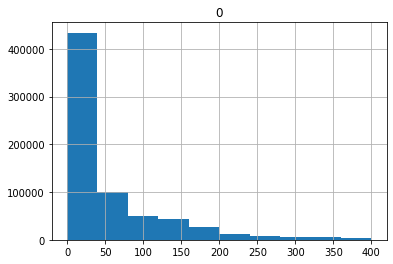

In [ ]:
times.loc[(times[0] > 0) & (times[0] < 400)].hist()

Распредление явно ассиметрично и позволяет утверждать, что большое количество заказов пользователи стремятся получить в течение суток после оформления заказа. Присутствует, однако, также и значимая часть заказов, которые оформляются на несколько суток или даже не неделю вперед. Такие заказы можно объянить, например, офисными закупками, которые оформляются преждевременно 

#**Использование промоакций**

Интересно посмотреть на то, насколько активно используются промоакции (какой процент заказов оформлялся с применением промокодов). Данный показатель может говорить о том, насколько такой способ продвижения интернет магазина эффективен

In [ ]:
promos = request("select item_total, promo_total, cost, total_cost from orders")
print("Процент заказов, оформленных с применением промокода:", round(100 * len(promos.loc[(promos[1] != 0) | (promos[2] != promos[3])]) / len(promos), 2))

Процент заказов, оформленных с применением промокода: 59.53


Также интересно посмотреть на то, какую скидку от общего чека вместе с доставкой в среднем дают промокоды

In [ ]:
print("Средняя скидка на заказ с доставкой в процентах:",\
      round(100 * request("select (abs(promo_total) + (cost - total_cost)) / (item_total + cost) from orders where item_total != 0 and total_cost != 0")[0].mean(), 2))

Средняя скидка на заказ с доставкой в процентах: 2.73


Таким образом, можно утвержать, что при относительно небольшой предлагаемой скидке, удается добиться высокой эффективности от промоакций

#**Количетсво единиц товара в заказах**

Важным показателем является колличество товаров в потребительской корзине. На основании знаний о распредлении этой величины можно делать более объективные оценки на время сбора заказа курьером. Посмотрим на распределение:

In [ ]:
quantity = request("select total_quantity from orders")
print("Квантиль уровня 0.95:", quantity[0].quantile(0.95))

Квантиль уровня 0.95: 101.0


Итак, почти 95% заказов включают в себя не больше 100 единиц товара. Дабы более детально посмотреть на распредление типичных заказов, удалим из данных все заказы, количество товаров в которых превышает 100

In [ ]:
aux = quantity.loc[quantity[0] < 100]
print("Средний размер корзины:", round(aux[0].mean()))

Средний размер корзины: 35


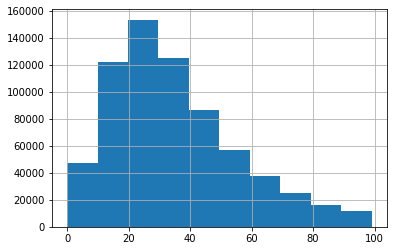

In [ ]:
aux[0].hist()

Итак, распределение обладает ярко выраженным пиком, а средним значением является 35 товаров на корзину. 

#**Замены и отмены**

По проценту заказов, в которых были произведены замены или отмены необходимых товаров, можно судить о проблемах с логистикой поставки внутри компании ритейлера, качестве организации торговых прилавков в магазинах или же быстроте обновления информации о наличии товара на сайте Сбермаркета

In [ ]:
replacements = request("select retailer_id, 100 * count(distinct order_id) / count(distinct orders.id) from orders inner join stores on orders.store_id = stores.id left join replacements on orders.id = replacements.order_id group by retailer_id")
cancellations = request("select retailer_id, 100 * count(distinct order_id) / count(distinct orders.id) from orders inner join stores on orders.store_id = stores.id left join cancellations on orders.id = cancellations.order_id group by retailer_id")

In [ ]:
replacements = replacements.rename(columns={0: "retailer_id", 1: "percentage"})
cancellations = cancellations.rename(columns={0: "retailer_id", 1: "percentage"})

In [ ]:
replacements

,retailer_id,percentage
0,1,54
1,8,74
2,15,79
3,16,44


In [ ]:
cancellations

,retailer_id,percentage
0,1,60
1,8,66
2,15,73
3,16,49


Как видно из таблиц, самые большие проблемы с заменами и отменами товаров имеют ритейлеры с id 8 и 15. Однако, даже у ритейлера с id 16, около половины всех заказов изменяются на этапе сборки.

Можно заключить, что большой проблемой является недостаточная скорость обновления данных о наличии товаров на сайте Сбермаркета. Не стоит также и исключать человеческий фактор при сборке заказов в больших супермаркетах. Помимо прочего, проблема может скрываться в заказах, которые оформляют преждевременно. Наличие товара на момент оформления заказа не гарантирует его наличия на этапе сборки. Недовольство подобными ситуациями со стороны покупателей можно сгладить, если помещать на страницу товаров, которые обладают высокой популярностью, но редкими поставками, предупреждение о том, что на момент сборки заказа, товара может не оказаться в наличии.

